In [22]:
#Spark 3
#Adornado B. Cabalbag Jr.
#BSIT - 3B

In [1]:
!pip install pyspark
!pip install nltk

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace,explode, split, count, when
import nltk
from nltk.corpus import stopwords

#Download stopwords for text cleaning
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [23]:
spark = SparkSession.builder.appName("TwitterDataPreprocessing").getOrCreate()

data = [
  (1, "@user1 Marcos administration's new policies are promising. #Philippines #Politics"),
  (2, "The government should focus on poverty reduction, not just infrastructure!"),
  (3, "Leni Robredo's leadership during the pandemic was commendable! #VP"),
  (4, "BBM's economic plan is questionable. What do you think?"),
  (5, "The elections were rigged! Corruption is everywhere. #FakeNews"),
  (6, "The budget for education should be increased. #DepEd"),
  (7, "Why is the media so biased against Duterte?"),
  (8, "Sara Duterte is being groomed for presidency. Smart move?"),
  (9, "We need more transparency in government spending!"),
  (10, "The opposition lacks a clear agenda. What's their plan?")
]

columns = ["Tweet_ID", "Tweet_Text"]

#Convert the list to a Spark DataFrame
df = spark.createDataFrame(data, columns)

#Show raw data
df.show (truncate=False)


+--------+---------------------------------------------------------------------------------+
|Tweet_ID|Tweet_Text                                                                       |
+--------+---------------------------------------------------------------------------------+
|1       |@user1 Marcos administration's new policies are promising. #Philippines #Politics|
|2       |The government should focus on poverty reduction, not just infrastructure!       |
|3       |Leni Robredo's leadership during the pandemic was commendable! #VP               |
|4       |BBM's economic plan is questionable. What do you think?                          |
|5       |The elections were rigged! Corruption is everywhere. #FakeNews                   |
|6       |The budget for education should be increased. #DepEd                             |
|7       |Why is the media so biased against Duterte?                                      |
|8       |Sara Duterte is being groomed for presidency. Smart move?   

In [24]:
#Remove User Mentions (@username)
df = df.withColumn("Tweet_Text", regexp_replace(col("Tweet_Text"), r'@\w+', ''))
df.show(truncate=False)

#Remove Hashtags (#hashtag)
df = df.withColumn("Tweet_Text", regexp_replace(col("Tweet_Text"), r'#\w+', ''))
df.show(truncate=False)

#Remove Special Characters, Links, Emojis
df = df.withColumn("Tweet_Text", regexp_replace(col("Tweet_Text"), r"http\S+|[^a-zA-z\s]", ''))
df.show(truncate=False)


+--------+---------------------------------------------------------------------------+
|Tweet_ID|Tweet_Text                                                                 |
+--------+---------------------------------------------------------------------------+
|1       | Marcos administration's new policies are promising. #Philippines #Politics|
|2       |The government should focus on poverty reduction, not just infrastructure! |
|3       |Leni Robredo's leadership during the pandemic was commendable! #VP         |
|4       |BBM's economic plan is questionable. What do you think?                    |
|5       |The elections were rigged! Corruption is everywhere. #FakeNews             |
|6       |The budget for education should be increased. #DepEd                       |
|7       |Why is the media so biased against Duterte?                                |
|8       |Sara Duterte is being groomed for presidency. Smart move?                  |
|9       |We need more transparency in gove

In [25]:
#Convert to Lowercase
df = df.withColumn("Tweet_Text", lower(col("Tweet_Text")))
df.show(truncate=False)

#Tokenize Words (Split Into List of Words)
df = df.withColumn("Words", split(col("Tweet_Text"), " "))
df.show(truncate=False)



+--------+------------------------------------------------------------------------+
|Tweet_ID|Tweet_Text                                                              |
+--------+------------------------------------------------------------------------+
|1       | marcos administrations new policies are promising                      |
|2       |the government should focus on poverty reduction not just infrastructure|
|3       |leni robredos leadership during the pandemic was commendable            |
|4       |bbms economic plan is questionable what do you think                    |
|5       |the elections were rigged corruption is everywhere                      |
|6       |the budget for education should be increased                            |
|7       |why is the media so biased against duterte                              |
|8       |sara duterte is being groomed for presidency smart move                 |
|9       |we need more transparency in government spending                  

In [26]:
#Remove Stopwords
#Get list of stopwords
stop_words = set(stopwords.words("english"))
additional_stopwords = {"marcos", "duterte", "sara", "bbms", "leni"} #Custom stopwords
stop_words.update(additional_stopwords)
df.show(truncate=False)

#Define UDF (User-Defined Function) to filter stopwords
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType

def remove_stopwords(words):
  return [word for word in words if word not in stop_words and word !=""]

remove_stopwords_udf = udf(remove_stopwords, ArrayType(StringType()))

df = df.withColumn("Filtered_Words", remove_stopwords_udf(col("Words")))

#Show cleaned dataset
df.select("Tweet_ID", "Filtered_Words").show(truncate=False)

+--------+------------------------------------------------------------------------+-----------------------------------------------------------------------------------+
|Tweet_ID|Tweet_Text                                                              |Words                                                                              |
+--------+------------------------------------------------------------------------+-----------------------------------------------------------------------------------+
|1       | marcos administrations new policies are promising                      |[, marcos, administrations, new, policies, are, promising, , ]                     |
|2       |the government should focus on poverty reduction not just infrastructure|[the, government, should, focus, on, poverty, reduction, not, just, infrastructure]|
|3       |leni robredos leadership during the pandemic was commendable            |[leni, robredos, leadership, during, the, pandemic, was, commendable, ]      

In [27]:
#Explode words into separate rows
df_exploded = df.select(explode(col("Filtered_Words")).alias("Word"))

#Count occurences of words
word_counts = df_exploded.groupBy("Word").count().orderBy(col("count").desc())

#Show most common words
word_counts.show()

+---------------+-----+
|           Word|count|
+---------------+-----+
|           plan|    2|
|     government|    2|
|   questionable|    1|
|administrations|    1|
|       pandemic|    1|
|     everywhere|    1|
|            new|    1|
|      reduction|    1|
|     leadership|    1|
| infrastructure|    1|
|        poverty|    1|
|       policies|    1|
|    commendable|    1|
|          focus|    1|
|     corruption|    1|
|       robredos|    1|
|      elections|    1|
|      promising|    1|
|         rigged|    1|
|       economic|    1|
+---------------+-----+
only showing top 20 rows



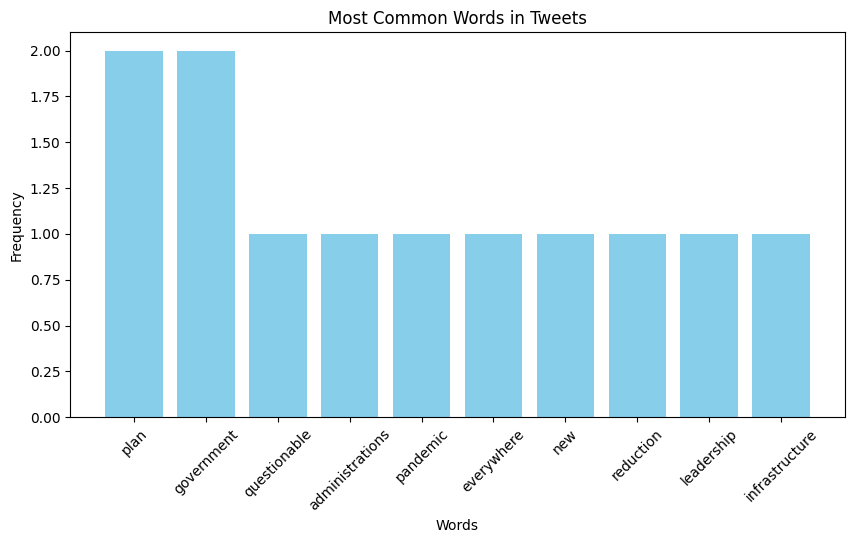

In [28]:
import matplotlib.pyplot as plt

#Convert Spark DataFrame to Pandas for visualization
word_counts_pd = word_counts.limit(10).toPandas()

#Plot bar chart
plt.figure(figsize=(10, 5))
plt.bar(word_counts_pd["Word"], word_counts_pd["count"], color="skyblue")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Most Common Words in Tweets")
plt.xticks (rotation=45)
plt.show()

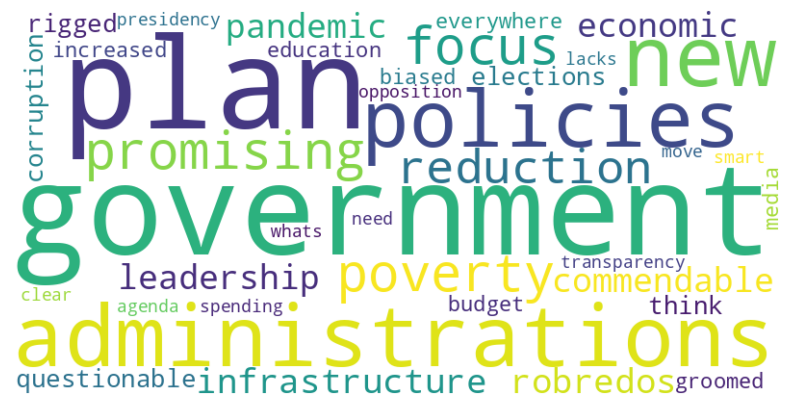

In [29]:
from wordcloud import WordCloud

#Generate a string of all word
text = " ".join(df_exploded.select("Word").rdd.flatMap(lambda x: x).collect())

#Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

#Display the word cloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

spark.stop()